# DM-35922 : document where the wavefront is calculated in `ts_wep` 

Author: Chris Suberlak (@suberlak)

Last Verified to Run: 2022-08-18

Software Versions:

* ts_wep: **v2.5.4**
* lsst_distrib: **w_2022_32**

We know that `ts_ofc`  expects as part of the loop already a sensor-averaged  wavefront error estimate (called in butler outputZernikesAvg  https://github.com/lsst-ts/ts_phosim/blob/2a06807d495eb21e38aac196b0c88d6842de0f72/python/lsst/ts/phosim/CloseLoopTask.py#L660). Indeed, immediately  `ts_ofc` checks if there is exactly as many wavefront error arrays as field indices https://github.com/lsst-ts/ts_ofc/blob/761a71adde8ee75353ec6d9fed06dd9dd5ce79af/python/lsst/ts/ofc/ofc.py#L146  . But a step earlier in `ts_wep`, before averaging, we calculate `outputZernikesRaw`  in https://github.com/lsst-ts/ts_wep/blob/3825b283de5664cdb88c3824298e096c2bc6fbf5/python/lsst/ts/wep/task/EstimateZernikesBase.py#L511 which comes directly from `Algorithm.py`  https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L785 . 

Thus here we explore parts of `Algorithm.py`, to find out what happens at each stage. We use a recent simulation of corner sensor images with one star per sensor. 

In [4]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [6]:
def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog

def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0,
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId,
                          collections=[collection])
    return postIsr

In [7]:
repo_dir  = 'DM-35919_phosim_example/example_wfs/phosimData'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

In [8]:
sensor='R04'
extraImage = get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

Follow the steps of `EstimateZernikesBase`:

In [9]:
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# inside wfEsti = WfEstimator(instDir, algoDir)

# this is part of the init
inst = Instrument(instDir)
algo = Algorithm(algoDir)

# inside estimateZernikes()
instName='lsst'
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# inside wfEsti.config
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel = 0 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

# select the only donut pair in that corner
i=0
donutExtra = donutStampsExtra[i]
donutIntra = donutStampsIntra[i]

Show the two donut images

Text(0.5, 1.0, 'intra')

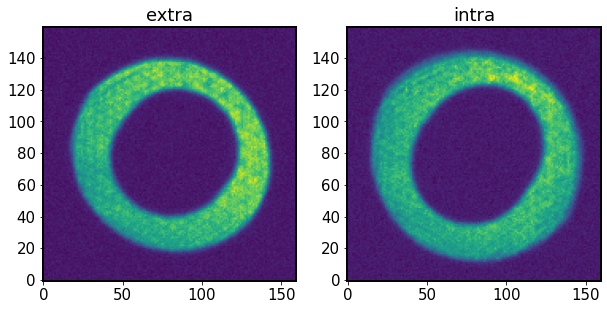

In [10]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(donutExtra.stamp_im.image.array, origin='lower')
ax[0].set_title('extra')
ax[1].imshow(donutIntra.stamp_im.image.array, origin='lower')
ax[1].set_title('intra')

In [11]:
# Inside EstimateZernikesBase
# Transpose field XY because CompensableImages below are transposed
# so this gets the correct mask orientation in Algorithm.py
fieldXYExtra = donutExtra.calcFieldXY()[::-1]
fieldXYIntra = donutIntra.calcFieldXY()[::-1]
print(fieldXYExtra, fieldXYIntra)

camera = donutExtra.getCamera() # same camera for both donuts
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)


# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

# now inside  `wfEsti.setImg` method,
# which inherits from `CompensableImage`
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

boundaryT = algo.getBoundaryThickness()

# right after we set the image, the compensable image mask is empty -
# it is only calculated later in Algorithm
maskScalingFactorLocal = 1

(-1.1895833333333334, 1.1253333333333333) (-1.1911944444444447, 1.2558333333333334)


At this point we would be calling `Algorithm.py` : 
    
    tol = 1e-3 # explicitly set the tolerance level ( this is default )
    algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)

In [12]:
# rename to just like it is in Algorithm.py
I1 = imgIntra
I2 = imgExtra
model = opticalModel
tol = 1e-3 

Dig inside `Algorithm.py`. We call `runIt` method which contains

    def runIt(self, I1, I2, model, tol=1e-3):
        
        # To have the iteration time initiated from global variable is to
        # distinguish the manually and automatically iteration processes.
        itr = self.currentItr
        while itr <= self.getNumOfOuterItr():
            stopItr = self._singleItr(I1, I2, model, tol)

            # Stop the iteration of outer loop if converged
            if stopItr:
                break

            itr += 1

The outer loop and inner loops. From `Algorithm.runIt` [docstring](https://github.com/lsst-ts/ts_wep/blob/40a62fd336ee7d150afa5ae4c7392b7001c6cfaf/python/lsst/ts/wep/cwfs/Algorithm.py#L539):

    The inner loop is to solve the Poisson's equation. The outer loop is to compensate the intra- and extra-focal images to mitigate the calculation of wavefront  (e.g. S = -1/(delta Z) * (I1 - I2)/ (I1 + I2)).




The `getNumOfOuterItr()` returns the number of outer iterations. 

In [13]:
algo.getNumOfOuterItr()


14

This is one of the settings in `policy/algo/exp.yaml` https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/algo/exp.yaml . The others are:

    # Algorithm parameters to solve the transport of intensity equation (TIE)

    # The way to solve the Poisson equation
    # fft: Fast Fourier transform method per Roddier & Roddier 1993
    # exp: Series expansion method per Guruyev & Nugent 1996
    poissonSolver: exp

    # Maximum number of Zernike polynomials supported
    numOfZernikes: 22

    # Obscuration ratio used in Zernike polynomials
    # 0: Standard filled
    # 1: Annular as defined by system in instParam.yaml
    # others (0 < x < 1): Use as the obscuration ratio
    obsOfZernikes: 1

    # Number of outer loop iteration when solving TIE
    numOfOuterItr: 14

    # Gain value used in the outer loop iteration
    feedbackGain: 0.6

    # Number of polynomial order supported in off-axis correction
    offAxisPolyOrder: 10

    # Method to compensate the wavefront by wavefront error
    # zer: Derivatives and Jacobians calculated from Zernike polynomials
    # opd: Derivitives and Jacobians calculated from wavefront map
    compensatorMode: zer

    # Compensate the image based on the Zk from the lower terms first according to
    # the sequence defined here
    # Sets compensated zernike order vs iteration
    compSequence: [4, 4, 6, 6, 13, 13, 13, 13, 22, 22, 22, 22, 22, 22]

    # Defines how far the computation mask extends beyond the pupil mask and, in
    # fft algorithm, it is also the width of Neuman boundary where the derivative
    # of the wavefront is set to zero
    boundaryThickness: 8


The compensated sequence above is explained in Xin2015, Sec 2A:

    To decouple Zernike terms with the same azimuthal frequency, for example, between tip- tilt and astigmatisms, and defocus and spherical aberration, only a certain number of low-order Zernike terms are compensated at each outer iteration. After the algorithm has converged on low-order terms, higher-order terms are added to the compensated wavefront. The tests we show in Section 4 each include 14 outer iterations, with the highest Zernike index of 4, 4, 6, 6, 13, 13, 13, 13, 22, 22, 22, 22, 22, and 22, respectively.


In [14]:
len(algo.getCompSequence())

14

We start from iteration 0 to 14:

In [15]:
itr = algo.currentItr
print(itr)

0


Then a `_singleItr` is  called, which contains

    def _singleItr(self, I1, I2, model, tol=1e-3):

In [16]:
# initially the compensable image has not been calculated 
type(I1.getImgInit())

NoneType

In [17]:
model

'offAxis'

In [18]:
# Use the zonal mode ("zer")
compMode = algo.getCompensatorMode()

# Define the gain of feedbackGain
feedbackGain = algo.getFeedbackGain()

We get the compensation mode ("zer") and feedback gain (0.6). From Xin2015 Sec.A: 
    
    Our compensation algorithm has an oversampling parameter, which enables subpixel resolution for the mapping between the pupil and image planes. We can choose to improve the compensation performance by increasing the subpixel sampling, but at a cost of computation time. Due to the fact that the compensation is based on geometrical ray-tracing, we always compensate on the original defocused images. A feedback gain less than unity is used to prevent large oscillation in the final wavefront estimation, i.e., upon each outer iteration only part of the residual is compensated.

If this is the first iteration, we calculate the mask for each image:

In [19]:
# Set the pre-condition
if algo.currentItr == 0:

    # Check this is the first time of running iteration or not
    if I1.getImgInit() is None or I2.getImgInit() is None:

        # Check the image dimension
        if I1.getImg().shape != I2.getImg().shape:
            print(
                "Error: The intra and extra image stamps need to be of same size."
            )
          

        # Calculate the pupil mask (binary matrix) and related
        # parameters
        boundaryT = algo.getBoundaryThickness()
        I1.makeMask(algo._inst, model, boundaryT, 1)
        I2.makeMask(algo._inst, model, boundaryT, 1)
        

Show the masks:

Text(0.5, 1.0, 'image*pupil mask')

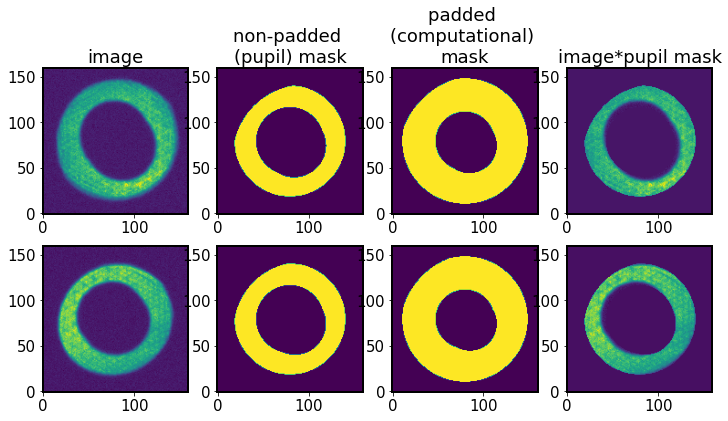

In [20]:
fig,ax = plt.subplots(2,4,figsize=(12,6))

# top row: intra img and mask 
for row, I, title in zip([0,1],
                         [I1,I2],
                         ['intra','extra']
                        ):
    ax[row,0].imshow(I.getImg(), origin='lower') # image 
    ax[row,1].imshow(I.getNonPaddedMask(), origin='lower') # pupil
    ax[row,2].imshow(I.getPaddedMask(), origin='lower') # comp
    ax[row,3].imshow(I.getImg()*I.getNonPaddedMask(), origin='lower')
    
row=0
ax[row,0].set_title('image')
ax[row,1].set_title('non-padded \n(pupil) mask')    
ax[row,2].set_title('padded \n(computational) \nmask')
ax[row,3].set_title('image*pupil mask')



The subsequent call to 

      algo._makeMasterMask(I1, I2, algo.getPoissonSolverName())

creates a master mask, which is the overlap region:

    # Get the overlap region of mask for intra- and extra-focal images.
    # This is to avoid the anomalous signal due to difference in
    # vignetting.
    self.mask_comp = I1.getPaddedMask() * I2.getPaddedMask()
    self.mask_pupil = I1.getNonPaddedMask() * I2.getNonPaddedMask()
    
    
This is described in Xin2015 in Sec3D:


    The vignetting pattern still varies by field. To avoid anomalous signal due to the difference in vignetting from entering the wavefront estimation results, we mask off the intrafocal and extrafocal images using a common pupil mask, which is the logical AND of the pupil masks at the intrafocal and extrafocal field positions.



In [21]:
algo._makeMasterMask(I1, I2, algo.getPoissonSolverName())

Show the new masks:

Text(-0.6, 0.45, 'comp')

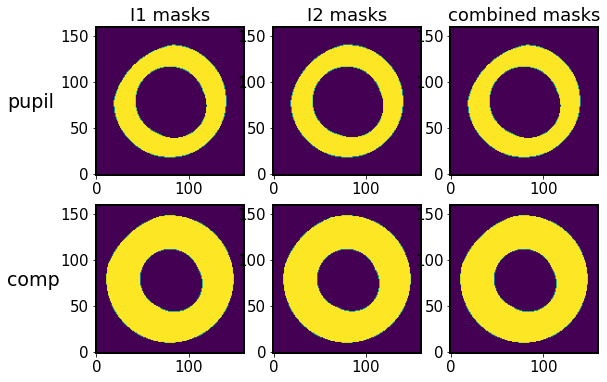

In [22]:
fig,ax = plt.subplots(2,3, figsize=(9,6))

row = 0
ax[row,0].imshow(I1.getNonPaddedMask(), origin='lower')
ax[row,1].imshow(I2.getNonPaddedMask(), origin='lower')
ax[row,2].imshow(algo.mask_pupil, origin='lower')
ax[row,0].set_title('I1 masks')
ax[row,1].set_title('I2 masks')
ax[row,2].set_title('combined masks')

row=1
ax[row,0].imshow(I1.getPaddedMask(), origin='lower')
ax[row,1].imshow(I2.getPaddedMask(), origin='lower')
ax[row,2].imshow(algo.mask_comp, origin='lower')



ax[0,0].text(-0.6,0.45, 'pupil', fontsize=19,transform=ax[0,0].transAxes)
ax[1,0].text(-0.6,0.45, 'comp', fontsize=19,transform=ax[1,0].transAxes)

Next we set the coefficients of off-axis correction for x, y-projection of intra- and extra-image. This is for the mapping of coordinate from the telescope aperture to defocal image plane. The model describes how the mask changes as a function of the off-axis distance, and is a linear interpolation of the ZEMAX model parameters. 

In [23]:
# Load the offAxis correction coefficients
if model == "offAxis":
    offAxisPolyOrder = algo.getOffAxisPolyOrder()
    I1.setOffAxisCorr(algo._inst, offAxisPolyOrder)
    I2.setOffAxisCorr(algo._inst, offAxisPolyOrder)


Next we cocenter the images. This means first finding the weighing center of the image binary (found by  default with https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/cwfs/CentroidRandomWalk.py) via `scipy.ndimage.center_of_mass` (https://github.com/lsst-ts/ts_wep/blob/40a62fd336ee7d150afa5ae4c7392b7001c6cfaf/python/lsst/ts/wep/cwfs/CentroidDefault.py#L76)

and the effective weighing radius, as 

    radius = np.sqrt(np.sum(imgBinary) / np.pi)



In [24]:
# store images before co-centering
I1imgInit = I1.getImg()
I2imgInit = I1.getImg()

Show what `imageCoCenter` does inside `CompensableImage`:

In [25]:
def imageCoCenterDiagnostic(I, inst, fov=3.5, debugLevel=0):
        """Shift the weighting center of donut to the center of reference
        image with the correction of projection of fieldX and fieldY.
        Parameters
        ----------
        inst : Instrument
            Instrument to use.
        fov : float, optional
            Field of view (FOV) of telescope. (the default is 3.5.)
        debugLevel : int, optional
            Show the information under the running. If the value is higher, the
            information shows more. It can be 0, 1, 2, or 3. (the default is
            0.)
        """

        # Calculate the weighting center (x, y) and radius
        x1, y1 = I._image.getCenterAndR()[0:2]

        # Show the co-center information
        if debugLevel >= 3:
            print("imageCoCenter: (x, y) = (%8.2f,%8.2f)\n" % (x1, y1))

        # Calculate the center position on image
        # 0.5 is the half of 1 pixel
        dimOfDonut = inst.getDimOfDonutOnSensor()
        stampCenterx1 = dimOfDonut / 2 + 0.5
        stampCentery1 = dimOfDonut / 2 + 0.5

        print('dimension of donut stamp:', dimOfDonut)
        print('x,y center:', stampCenterx1, stampCentery1)


        # Shift in the radial direction
        # The field of view (FOV) of LSST camera is 3.5 degree
        offset = inst.getDefocalDisOffset()
        pixelSize = inst.getCamPixelSize()
        radialShift = fov * (offset / 1e-3) * (10e-6 / pixelSize)
        print(f'defocal  offset in meters: {offset}, pixel size in meters: {pixelSize}')


        # Calculate the projection of distance of donut to center
        fieldDist = I._getFieldDistFromOrigin()
        radialShift = radialShift * (fieldDist / (fov / 2))

        print(f'field distance in degrees: {fieldDist}')
        print(f'radialShift in pixels :{radialShift}')

        # Do not consider the condition out of FOV of lsst
        if fieldDist > (fov / 2):
            radialShift = 0

        # Calculate the cos(theta) for projection
        I1c = I.fieldX / fieldDist

        # Calculate the sin(theta) for projection
        I1s = I.fieldY / fieldDist

        # Get the projected x, y-coordinate
        stampCenterx1 = stampCenterx1 + radialShift * I1c
        stampCentery1 = stampCentery1 + radialShift * I1s
        
        yshift = int(np.round(stampCentery1 - y1)) 
        xshift = int(np.round(stampCenterx1 - x1))
        
        print(f'xshift:{xshift} [px], yshift:{yshift} [px]')
        
        return xshift, yshift

We shift the image in the x and y direction given the 

    stampCenterx1 = stampCenterx1 + radialShift * cos(theta)
    stampCentery1 = stampCentery1 + radialShift * sin(theta)
    
using `np.roll` :
    
    np.roll(self.getImg(), int(np.round(stampCentery1 - y1)), axis=0)
    
We print the diagnostic below:

In [26]:
I1shifts = imageCoCenterDiagnostic(I1, algo._inst, fov=3.5, debugLevel=3)

imageCoCenter: (x, y) = (   80.47,   80.96)

dimension of donut stamp: 160
x,y center: 80.5 80.5
defocal  offset in meters: 0.0015, pixel size in meters: 1e-05
field distance in degrees: 1.7309135060962522
radialShift in pixels :5.1927405182887565
xshift:-4 [px], yshift:3 [px]


In [27]:
I2shifts = imageCoCenterDiagnostic(I2, algo._inst, fov=3.5, debugLevel=3)

imageCoCenter: (x, y) = (   79.66,   78.14)

dimension of donut stamp: 160
x,y center: 80.5 80.5
defocal  offset in meters: 0.0015, pixel size in meters: 1e-05
field distance in degrees: 1.6375236236633521
radialShift in pixels :4.912570870990057
xshift:-3 [px], yshift:6 [px]


Thus we shift by that many pixels in the y-direction. Similarly in the x-direction. The result is: 

In [28]:
# Cocenter the images to the center referenced to fieldX and
# fieldY. Need to check the availability of this.
I1.imageCoCenter(algo._inst, debugLevel=algo.debugLevel)
I2.imageCoCenter(algo._inst, debugLevel=algo.debugLevel)

Text(-0.6, 0.45, 'I2')

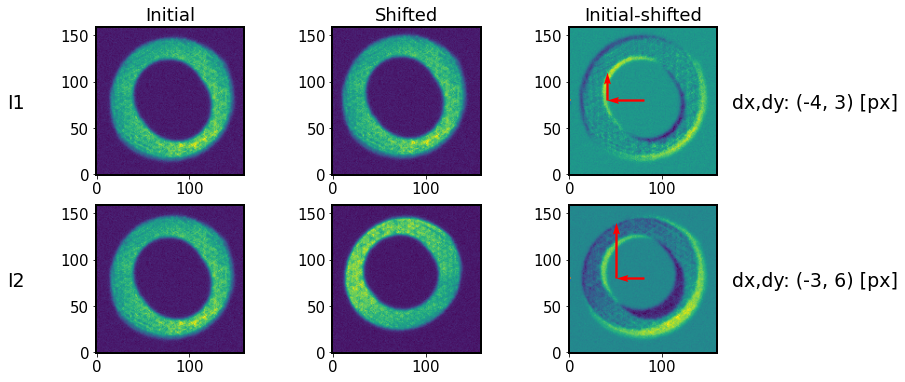

In [29]:
fig,ax = plt.subplots(2,3,figsize=(12,6))

dimOfDonut = algo._inst.getDimOfDonutOnSensor()
stampCenter = dimOfDonut / 2 + 0.5

for row,I,imgInit, shift in zip([0,1],
                         [I1,I2], 
                         [I1imgInit,I2imgInit],
                         [I1shifts, I2shifts]
                        ):
    ax[row,0].imshow(imgInit, origin='lower')
    ax[row,1].imshow(I.getImg(), origin='lower')
    ax[row,2].imshow(imgInit-I.getImg(), origin='lower')

    ax[row,2].plot([[stampCenter,stampCenter],[stampCenter+shift[0], stampCenter]],)
    
    # illustrate the shift with arrows
    x0 = stampCenter
    y0 = stampCenter
    dx = 10*shift[0]
    dy = 10*shift[1]
    # x-shift
    ax[row,2].quiver(x0,    y0, dx, 0,  scale=1, units="xy", scale_units="xy", 
                     width=2.5, edgecolors='orange', color='red')
    # y-shift 
    ax[row,2].quiver(x0+dx, y0,  0 ,dy, scale=1, units="xy", scale_units="xy", 
                     width=2.5,  edgecolors='orange', color='red')
    ax[row,2].text(1.1, 0.45, f'dx,dy: {shift} [px]',
                   transform=ax[row,2].transAxes,
                   fontsize=19,)
    
row=0
ax[row,0].set_title('Initial')
ax[row,1].set_title('Shifted')
ax[row,2].set_title('Initial-shifted')

ax[0,0].text(-0.6,0.45, 'I1', fontsize=19,transform=ax[0,0].transAxes)
ax[1,0].text(-0.6,0.45, 'I2', fontsize=19,transform=ax[1,0].transAxes)


The "shadow" indicates  a shift, marked by horizontal and vertical arrows (enlarged 10 times for illustration).

After the co-centering we save the image as the "initial" image, and start the computing variables `zcomp`, `zc` related to computed zernikes, `wcomp`, `West` related to wavefront estimate:

In [30]:
# Update the self-initial image
I1.updateImgInit()
I2.updateImgInit()

# Initialize the variables used in the iteration.
algo.zcomp = np.zeros(algo.getNumOfZernikes())
algo.zc = algo.zcomp.copy()

dimOfDonut = algo._inst.getDimOfDonutOnSensor()
algo.wcomp = np.zeros((dimOfDonut, dimOfDonut))
algo.West = algo.wcomp.copy()

algo.caustic = False



### Single iteration:


Each iteration compensates from the original image. The `compSequence` is taken from `exp.yaml`. The `ztmp` is filled with only as many elements of `compSequence` as the iteration number.

In [31]:
# Rename this index (currentItr) for the simplification
jj = algo.currentItr

# Solve the transport of intensity equation (TIE)
if not algo.caustic:

    # Reset the images before the compensation
    I1.updateImage(I1.getImgInit().copy())
    I2.updateImage(I2.getImgInit().copy())
    
    if compMode == "zer":

        # Zk coefficient from the previous iteration
        ztmp = algo.zc.copy()

        # Do the feedback of Zk from the lower terms first based on the
        # sequence defined in compSequence
        if jj != 0:
            compSequence = algo.getCompSequence()
            print(compSequence)
            ztmp[int(compSequence[jj - 1]) :] = 0

        print(f'ztmp:{ztmp}')
        print(f'zcomp:{algo.zcomp}')
        print(f'feedbackGain:{feedbackGain}')
        print(f'ztmp*feedbackGain:{ztmp*feedbackGain}')

        # Add partial feedback of residual estimated wavefront in Zk
        algo.zcomp = algo.zcomp + ztmp * feedbackGain
        print(f'zcomp:{algo.zcomp}')

ztmp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
zcomp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
feedbackGain:0.6
ztmp*feedbackGain:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
zcomp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [75]:
# store the image so that nothing in the below will affect it 
intraBeforeCompensate = I1.getImg()

## BEGIN compensate

Now we forward the image to the pupil calling:
    
    # Remove the image distortion by forwarding the image to pupil
    I1.compensate(self._inst, self, self.zcomp, model)
    I2.compensate(self._inst, self, self.zcomp, model)

Show the details for the intra-focal image:

In [38]:
# the calculated coefficients of the wavefront
zcCol = algo.zcomp


# Dimension of image
sm, sn = I1.getImg().shape

print('Image dimension:', sm, sn)

# Dimension of projected image on focal plane
projSamples = sm

# Let us create a look-up table for x -> xp first.
luty, lutx = np.mgrid[
    -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),
    -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),

]

Image dimension: 160 160


The look-up table is a meshgrid - a matrix representation of donut template pixel coordinates:
    
   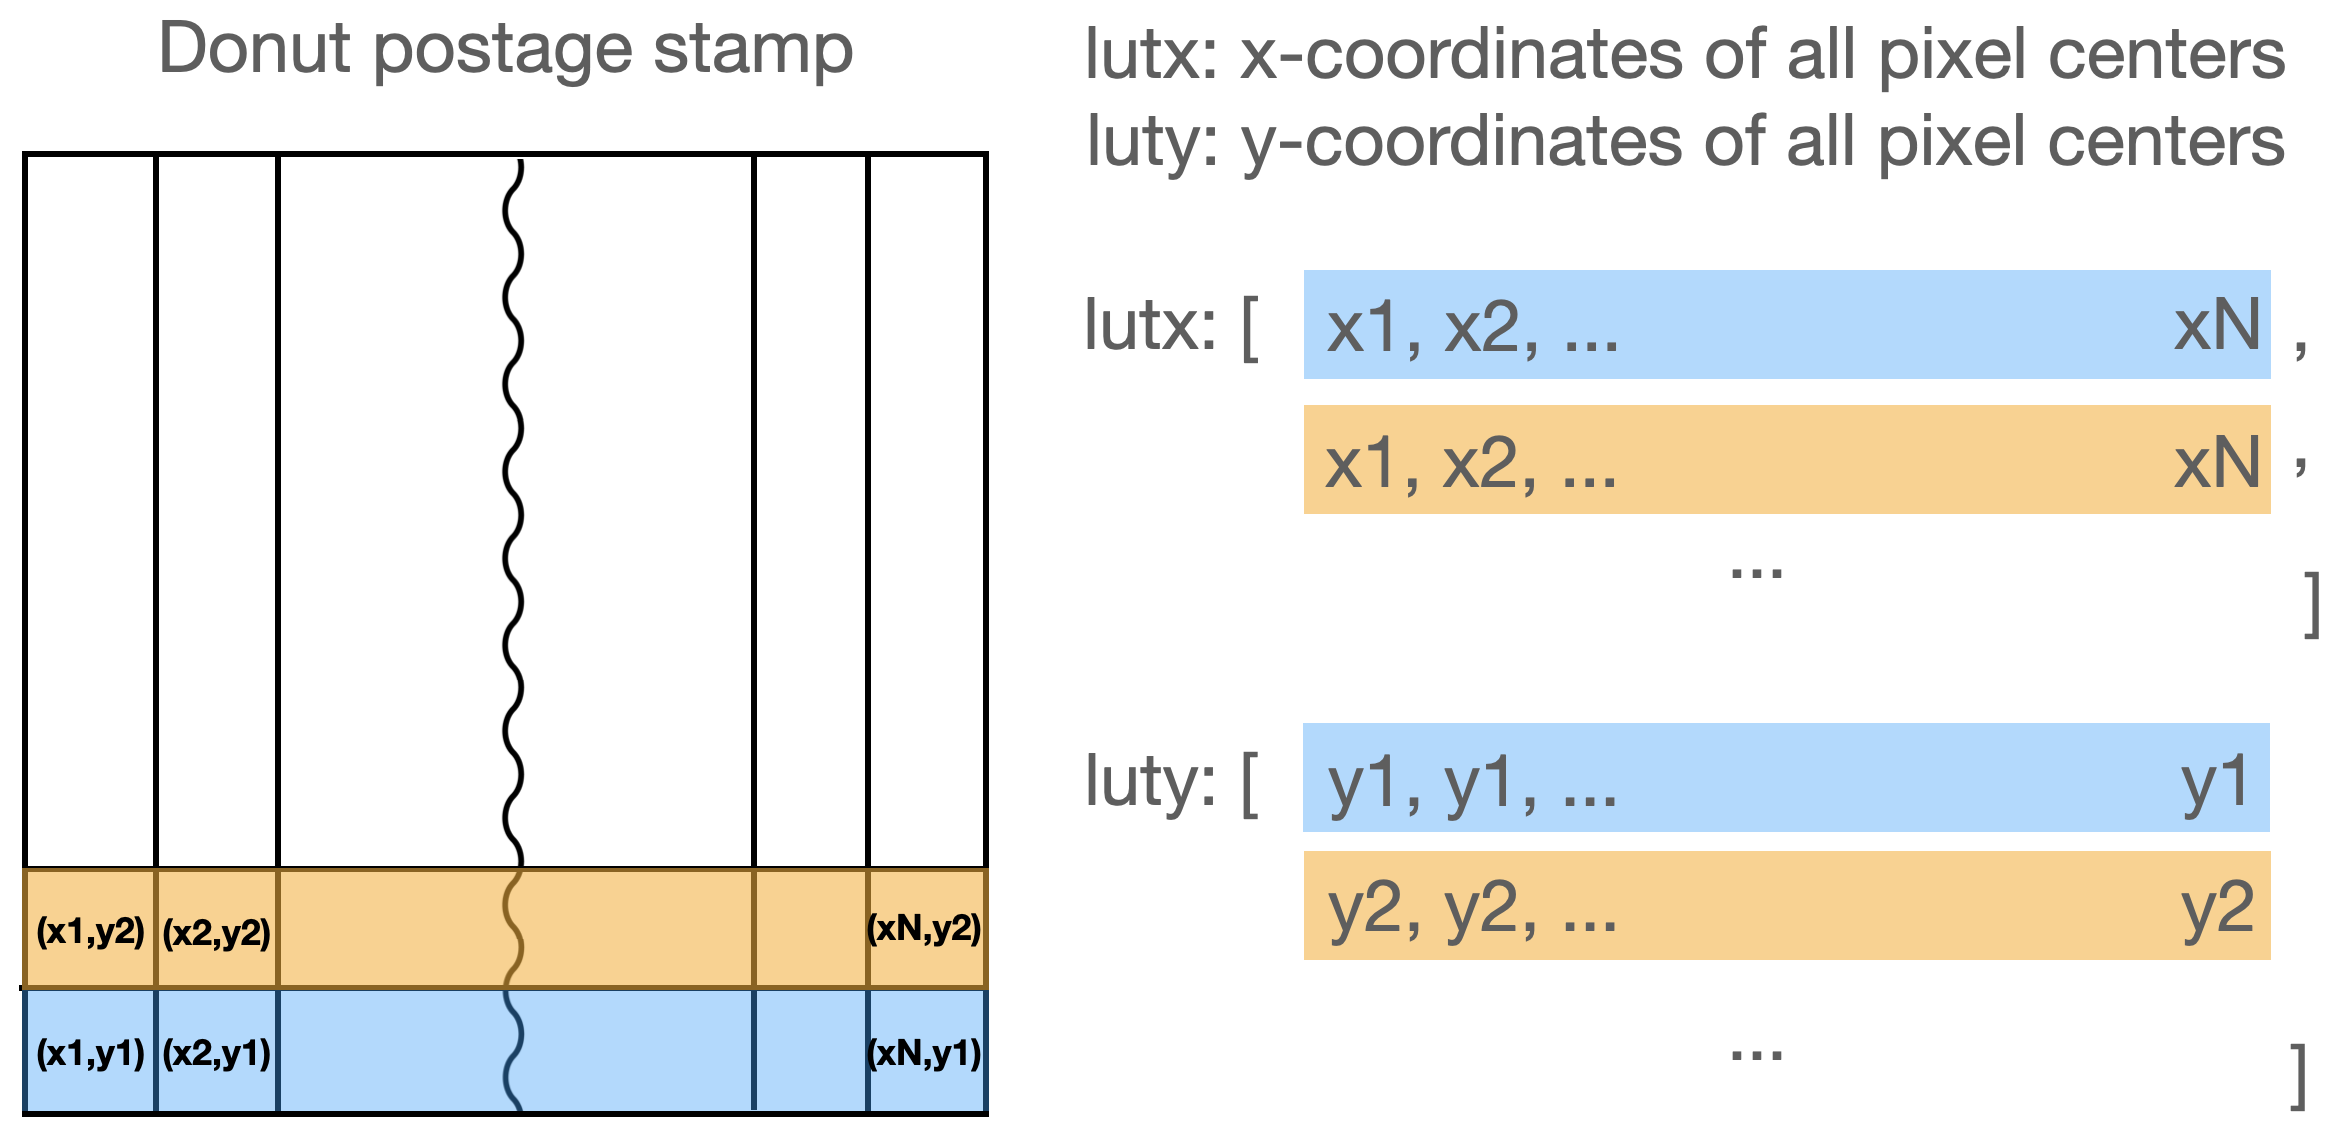

In [34]:
luty

array([[-79.5, -79.5, -79.5, ..., -79.5, -79.5, -79.5],
       [-78.5, -78.5, -78.5, ..., -78.5, -78.5, -78.5],
       [-77.5, -77.5, -77.5, ..., -77.5, -77.5, -77.5],
       ...,
       [ 77.5,  77.5,  77.5, ...,  77.5,  77.5,  77.5],
       [ 78.5,  78.5,  78.5, ...,  78.5,  78.5,  78.5],
       [ 79.5,  79.5,  79.5, ...,  79.5,  79.5,  79.5]])

Next we calculate the sensor factor:

In [39]:
sensorFactor = algo._inst.getSensorFactor()
lutx = lutx / (projSamples / 2 / sensorFactor)
luty = luty / (projSamples / 2 / sensorFactor)


In [40]:
sensorFactor

1.3157256778309412

The sensor factor is calculated as 

    offset = self.getDefocalDisOffset()
    apertureDiameter = self.getApertureDiameter()
    focalLength = self.getFocalLength()
    pixelSize = self.getCamPixelSize()
    sensorFactor = self.dimOfDonutImg / (
        offset * apertureDiameter / focalLength / pixelSize
    )
This notation is the same as 


    dimOfDonut * [ (focalLength*pixelSize) / (offset*apertureDiameter) ] ,
     
i.e.

    sensorFactor = dimOfDonut / donutSize
     
     

It is the ratio of donut template size to donut size. The donut size (denominator) is found given the simple geometry below: 

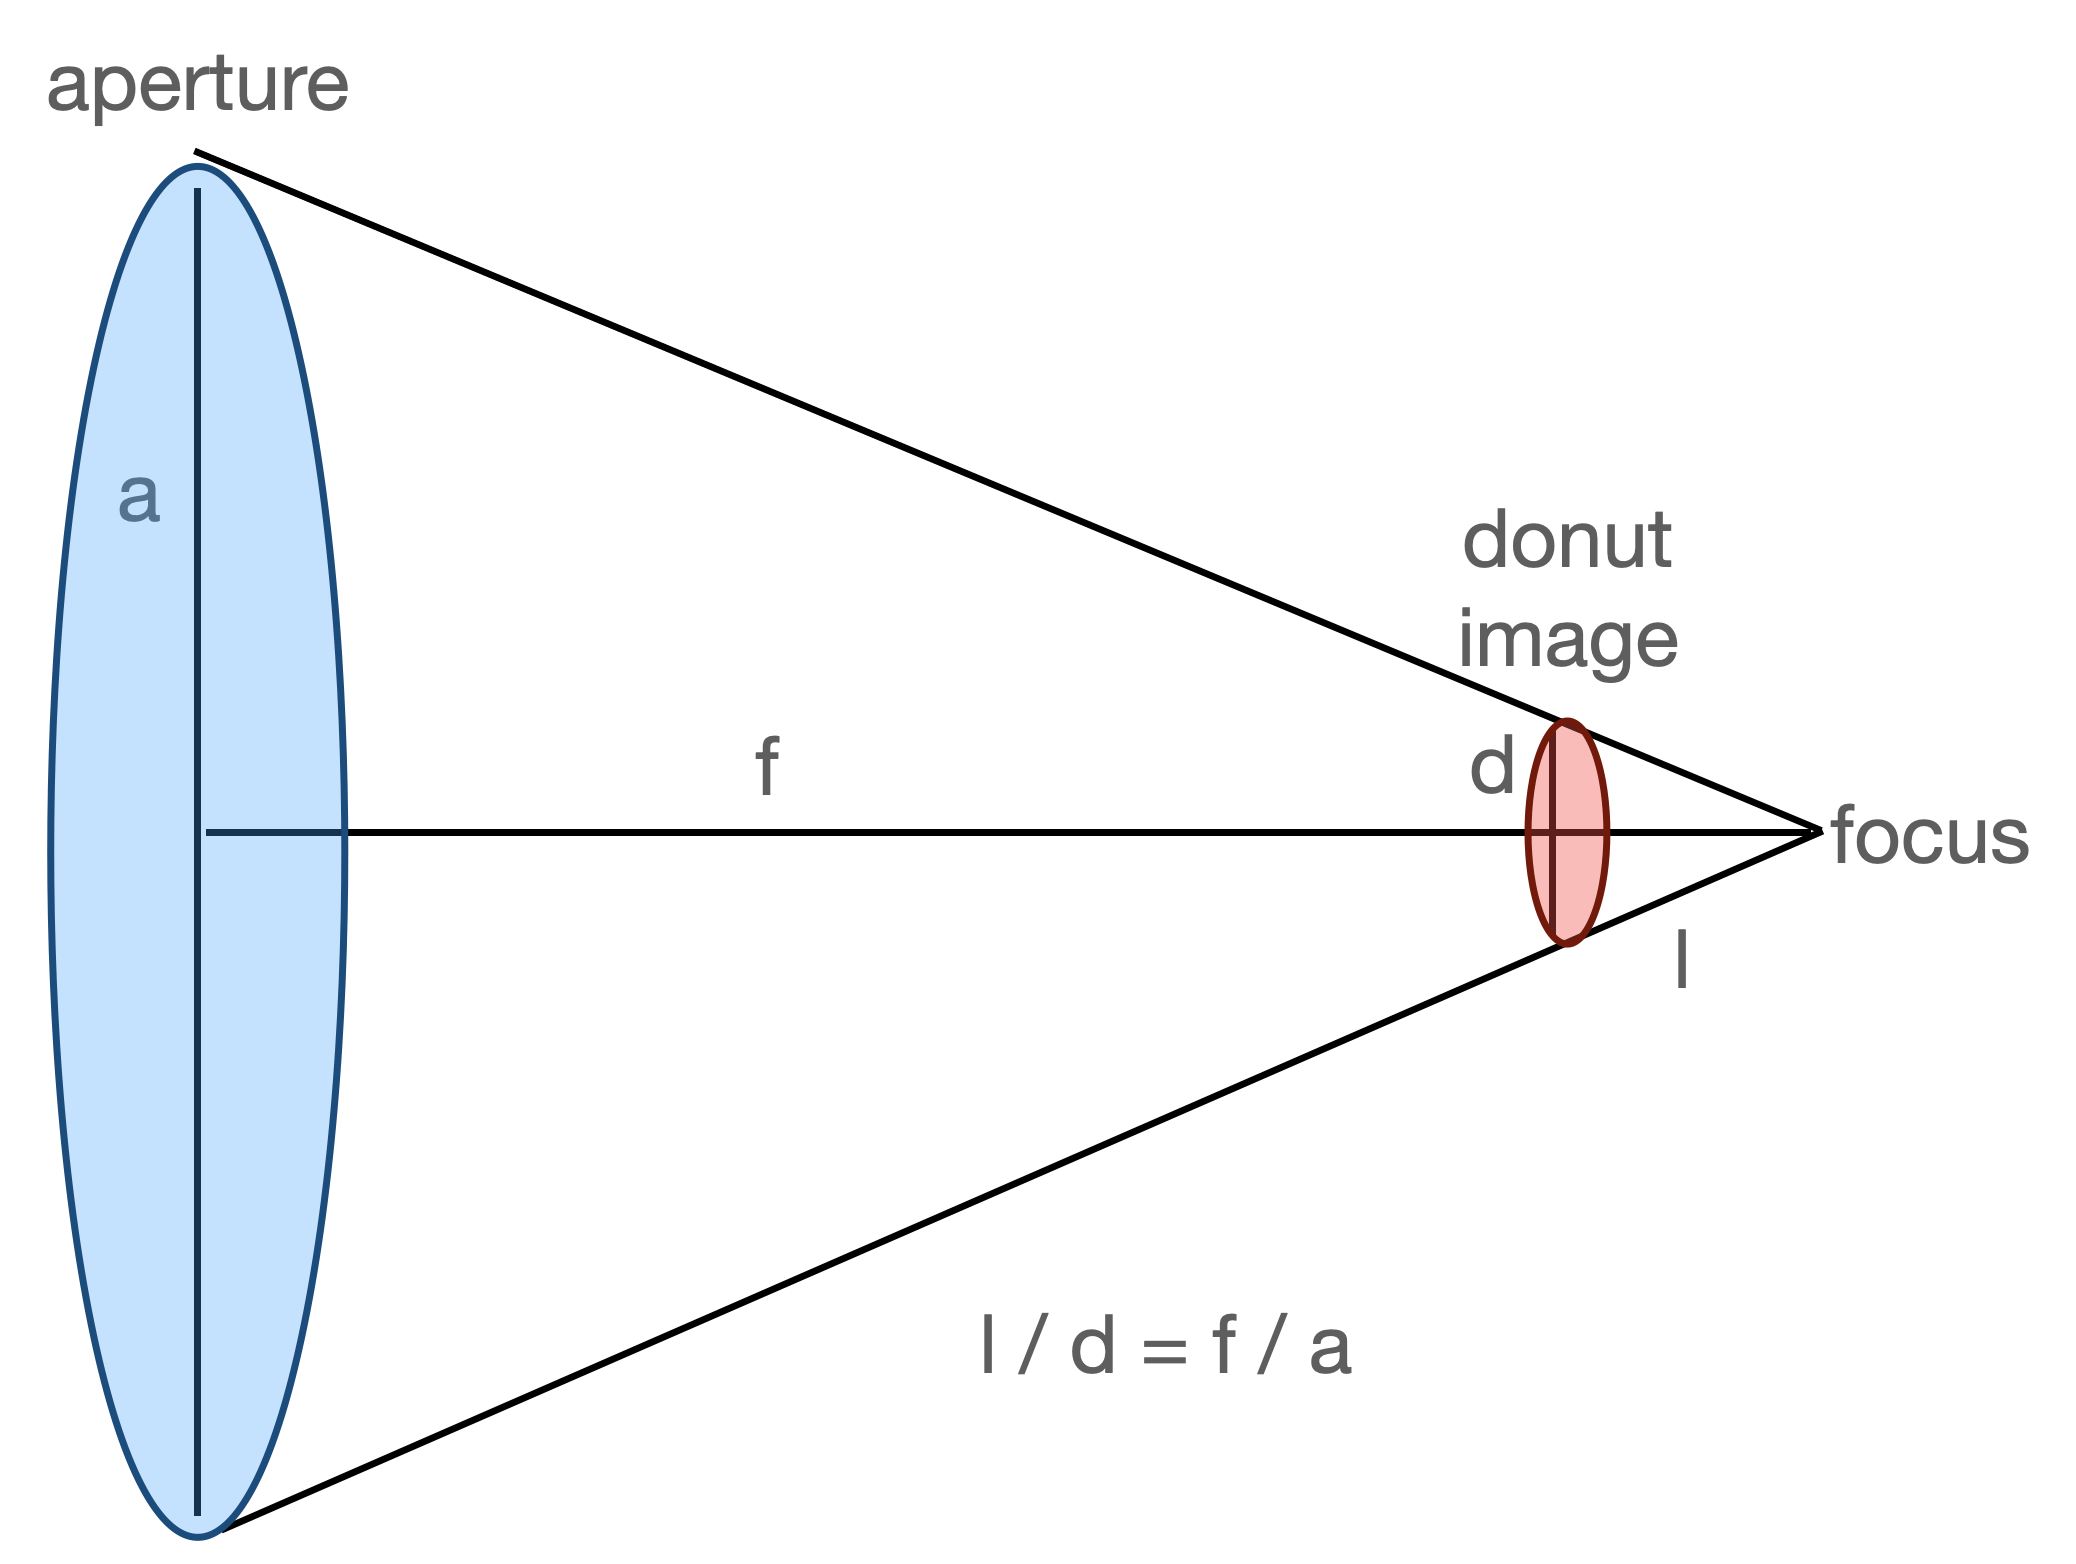

Now we calculate the mapping from the image plane to the pupil (aperture) plane : 

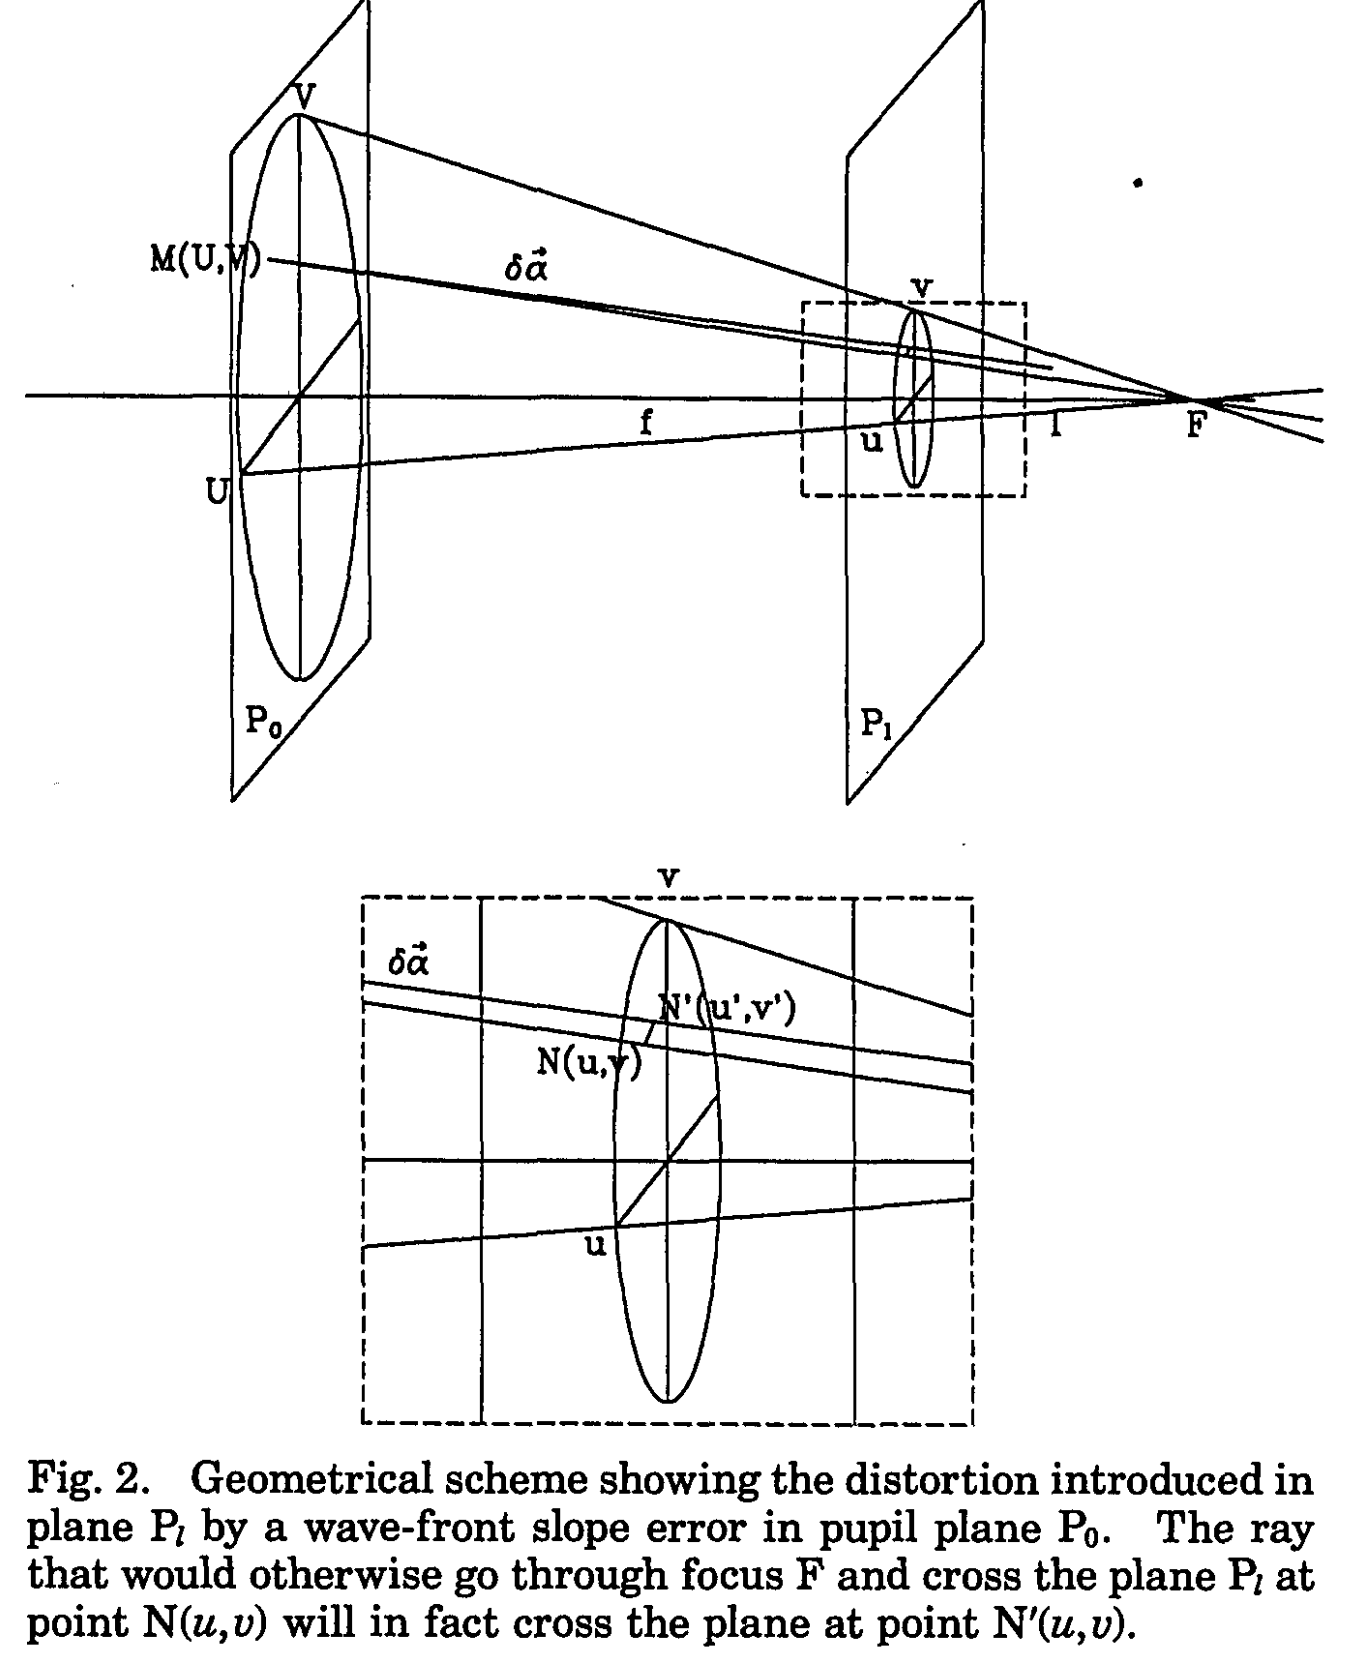

(Fig.2 Roddier&Roddier+1993)

We consider defocused images because differences in illumination will correspond to wavefront curvature (we assume uniform or nearly uniform illumination of the pupil). As in Roddier1987:

"From geometrical optics considerations,it is easy to show that a local wavefront curvature will produce an excess of illumination in one plane and a lack of illumination in the other plane. The difference between the two illuminations will therefore provide a measure of the local wavefront curvature. The result should be insensitive to irradiance fluctuations in the pupil plane since they will produce a similar change of illumination in both planes and the effect will cancel out in the difference."

As well as Xin2015:

"Assuming the intensity is equal to I0 everywhere inside the pupil and zero outside, we have the Neumann boundary conditions" 



"We compensate/correct the intrafocal and extrafocal images for the aberrations of the current wavefront estimate by remap- ping the image flux using the Jacobian of the wavefront in the pupil plane." (Xin2015, Sec2A) 

In [43]:
# Set up the mapping
lutxp, lutyp, J = I1._aperture2image(
inst, algo, zcCol, lutx, luty, projSamples, model
)

Let's investigate the `_aperture2image` function. It first sets up the transformation in reduced coordinates from image plane to pupil plane, following Xin2015 eq.(9)-(11):

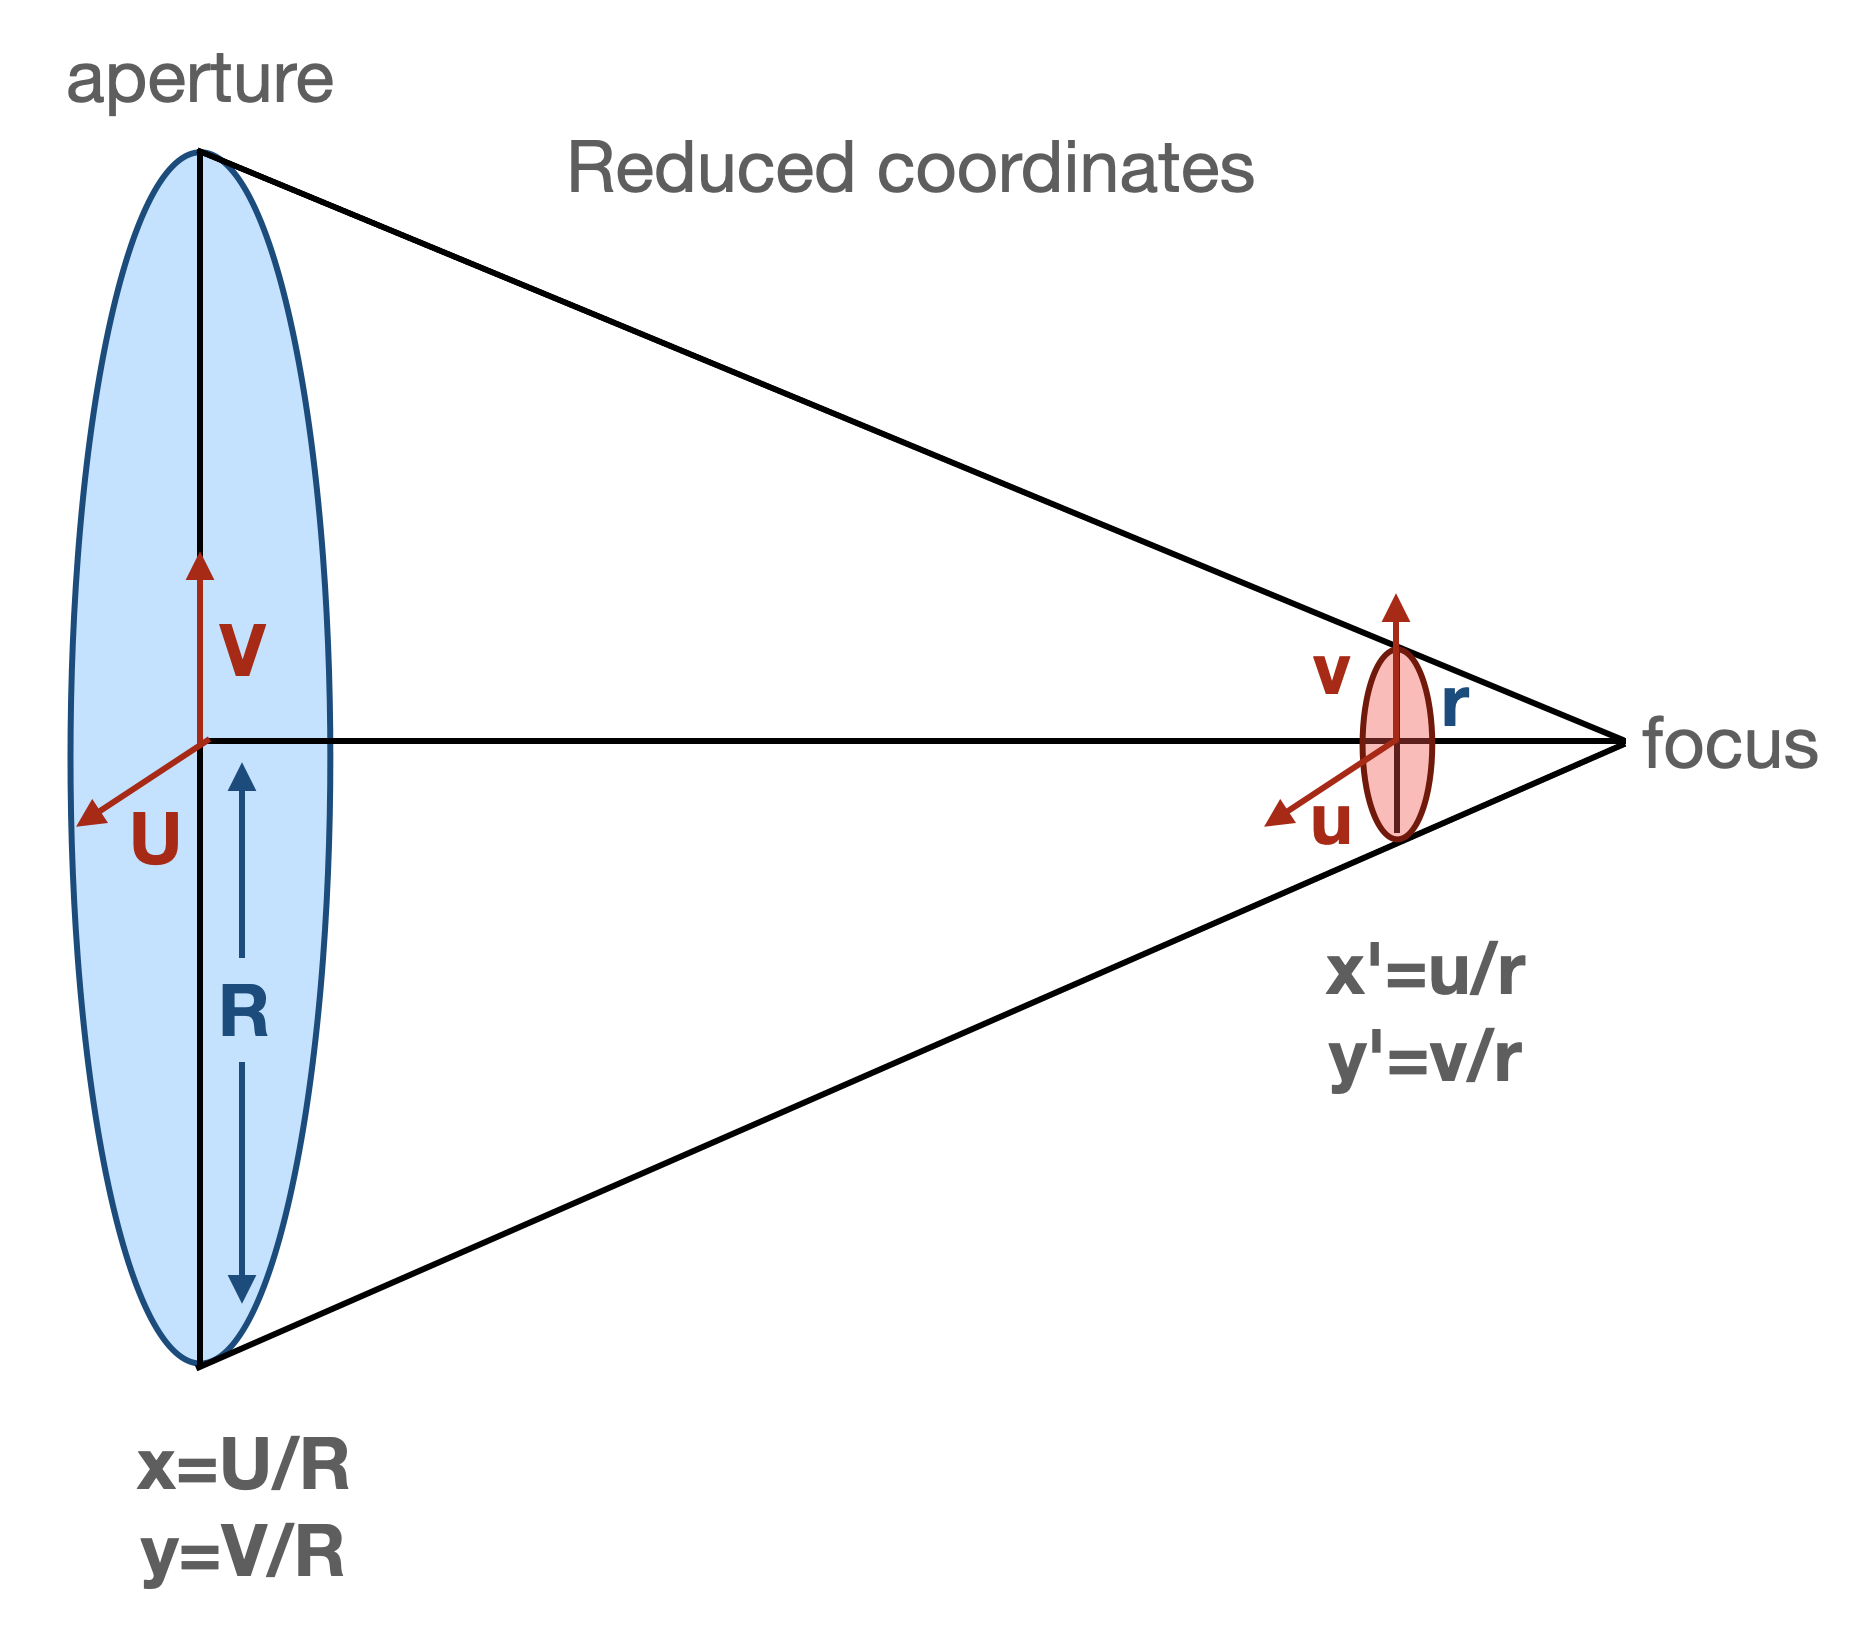

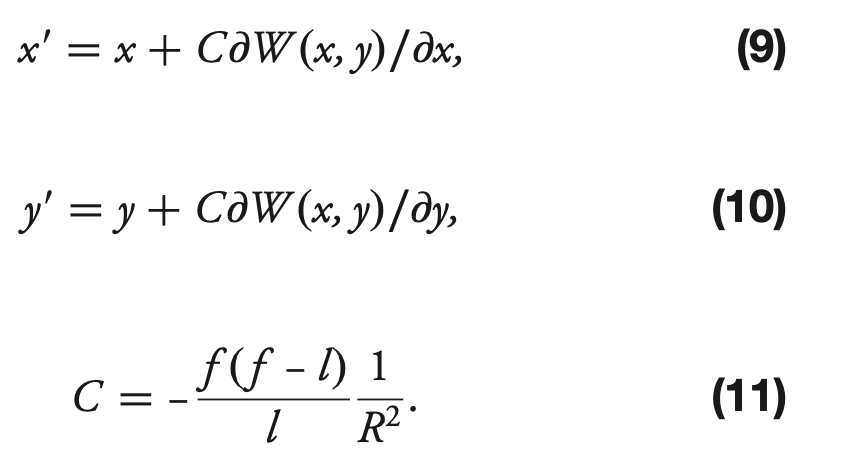

So in the code we have 

    # Get the radius: R = D/2
    R = inst.getApertureDiameter() / 2

    # Calculate C = -f(f-l)/l/R^2. This is for the calculation of reduced
    # coordinate.
    defocalDisOffset = inst.getDefocalDisOffset()
    if self.defocalType == DefocalType.Intra:
        l = defocalDisOffset
    elif self.defocalType == DefocalType.Extra:
        l = -defocalDisOffset

    focalLength = inst.getFocalLength()
    myC = -focalLength * (focalLength - l) / l / R**2

The further transformation from the donut coordinates `lutx` , `luty` to pupil coordinates `lutxp`, `lutyp` depends on the optical model. From [AOS discussions with Bo](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=56689538): 
* "paraxial" means the all incident light focuses into the focal point.
* "on-axis" allows the light from edge of lens (optical system) not to focus on the focal point. 
* "off-axis" allows the light comes in the off-axis direction, and the focal point is not (0,0) anymore. 

Ideally, the FieldXY=(0,0) in "off-axis" should give the same result as "on-axis".
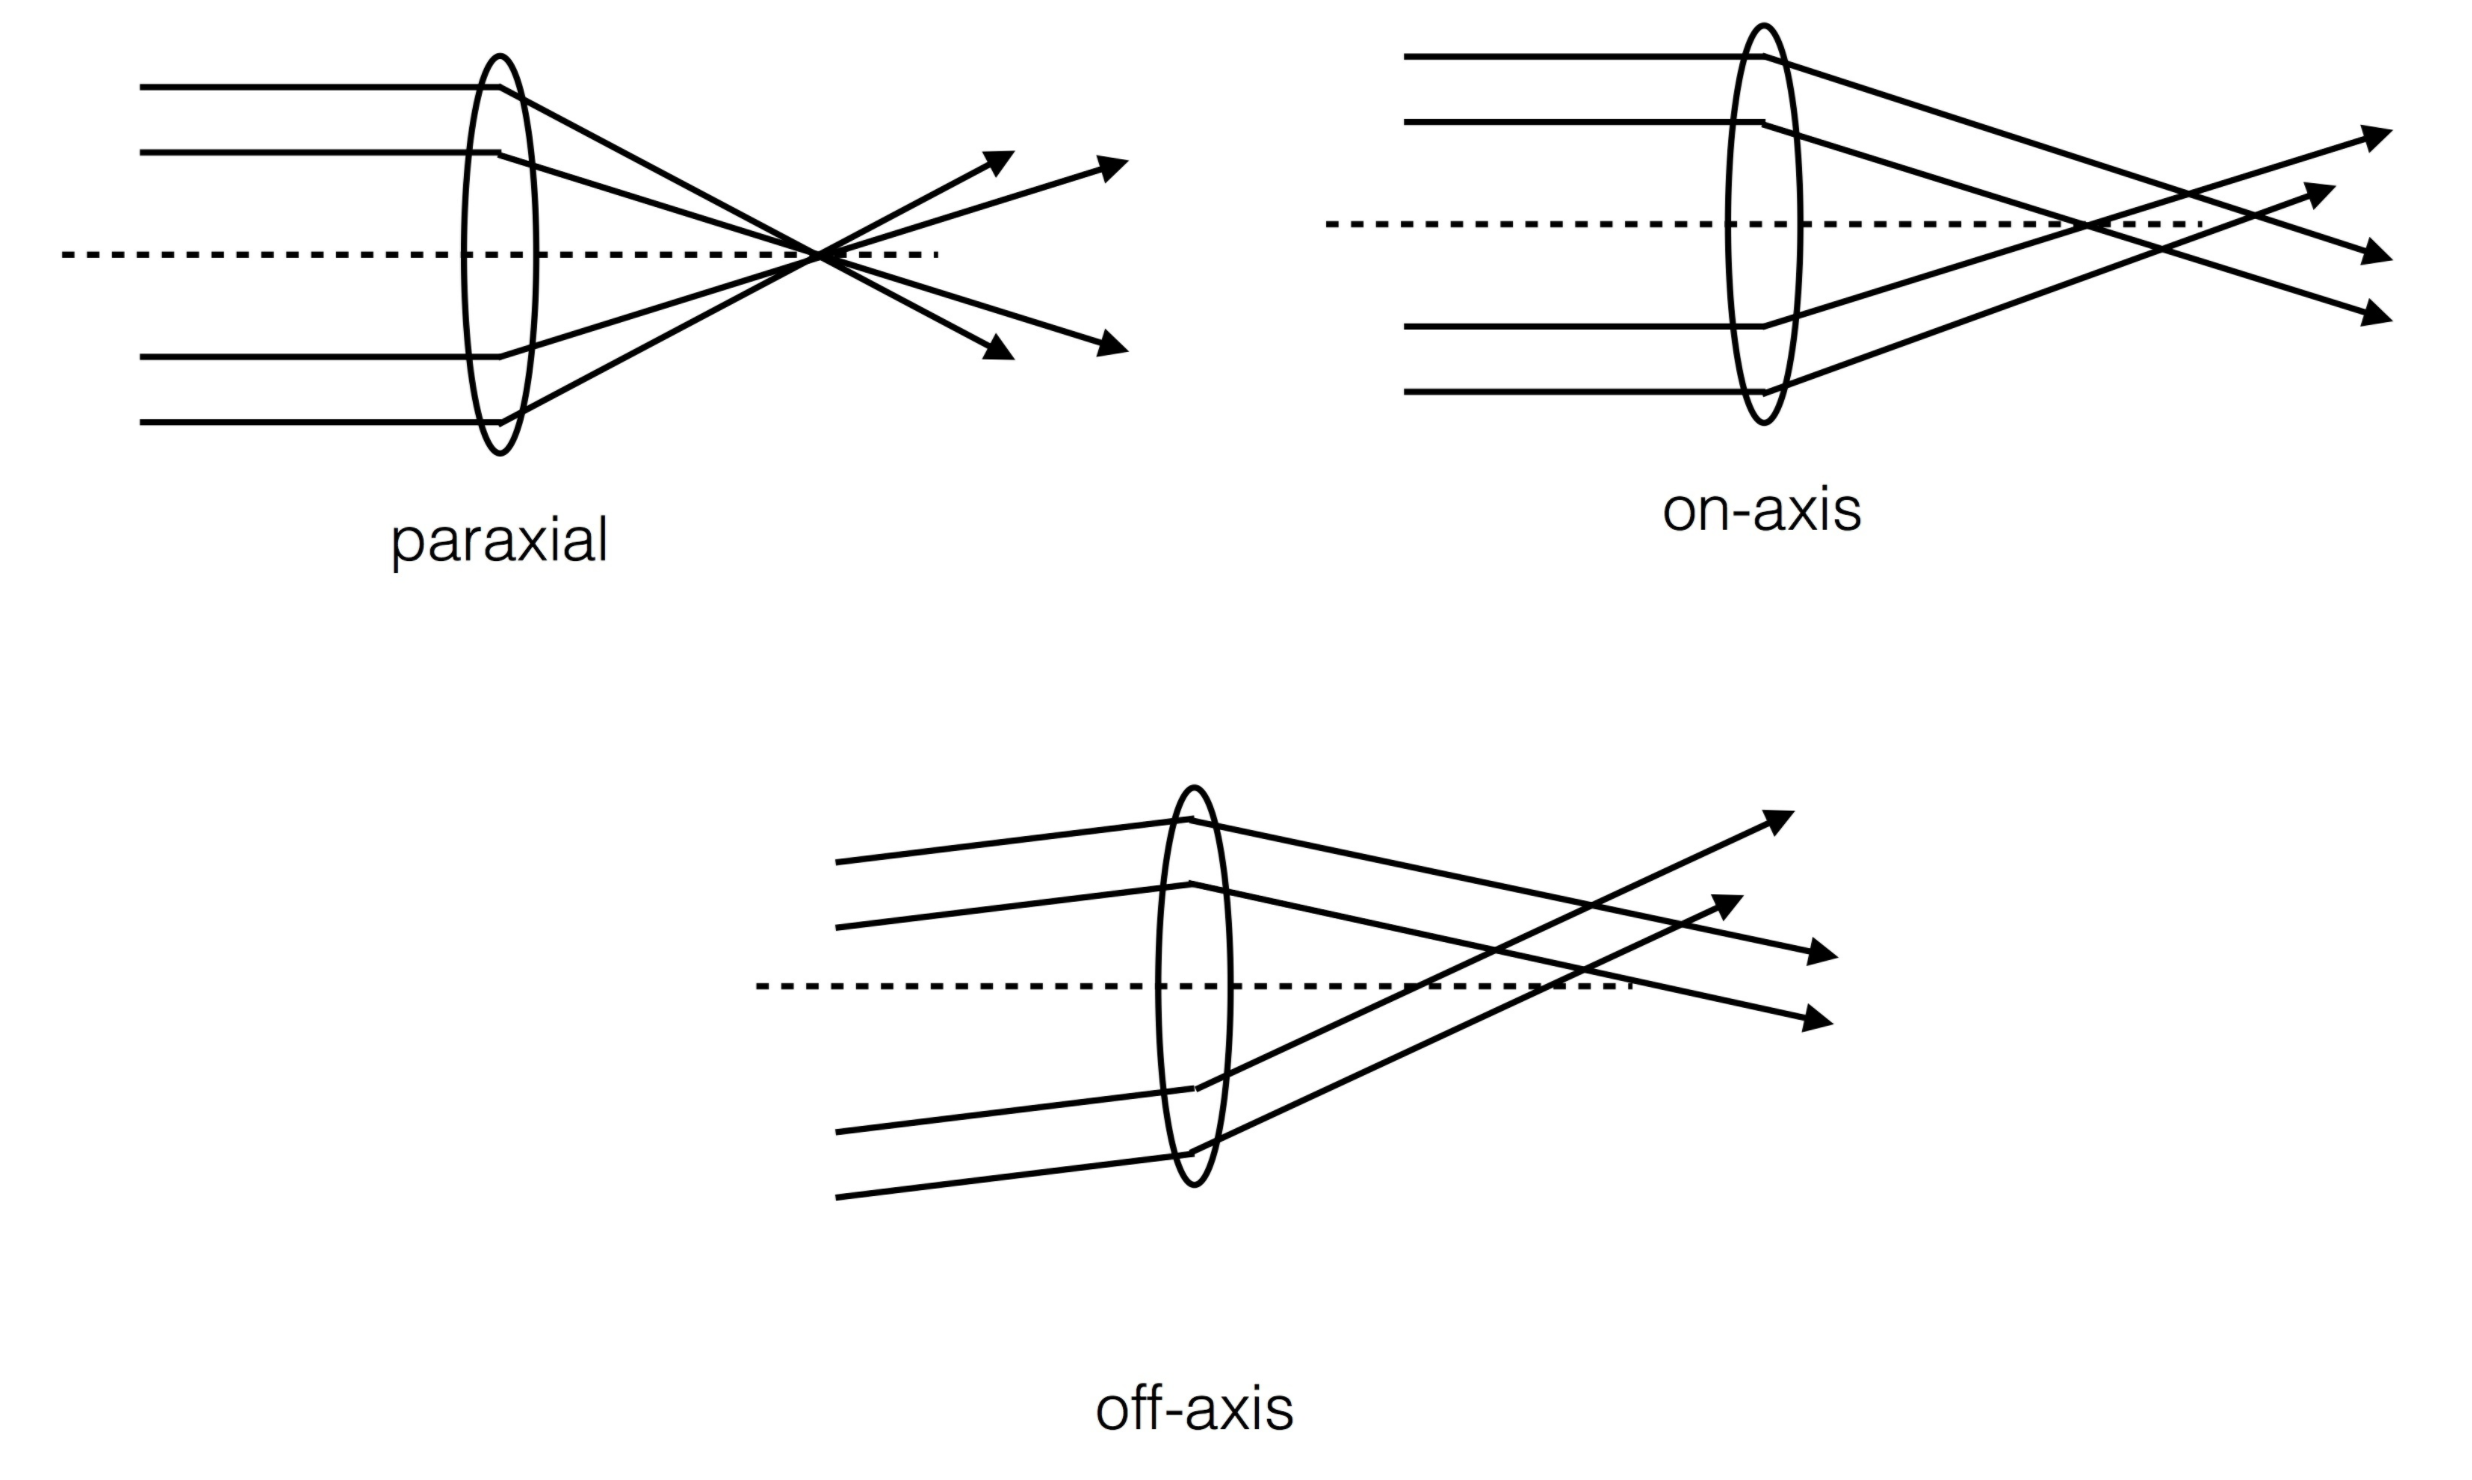
   
The "on-axis" model corrects for the fast beam : Xin+2015 Sec.3B

"In a fast-beam optical system like the LSST the wavefront error defined on the reference sphere at the exit pupil can no longer be projected on the pupil plane in a straightforward, linear way. The steepness of the fast-beam reference sphere results in non- linear mapping from the pupil (x–y plane) to the intrafocal and extrafocal images (x0 –y0 plane). Consequently, the intensity distribution on the aberration-free image is no longer uniform and would give rise to anomalous wavefront aberration estimates. This effect also causes the obscuration ratio as seen at the intrafocal and extrafocal image planes to be different from that on the pupil; thus the linear equations for the mapping between x–y and x0–y0 [Eqs. (9) and (10)] are no longer valid. Therefore, we need to quantify the **nonlinear fast-beam effect**, and be able to remove it so that the corrected images can be processed using the iterative FFT or the series expansion algorithms."

That's why for on-axis situation the equations (9)-(11) from Xin+2015 become (22)-(24) :  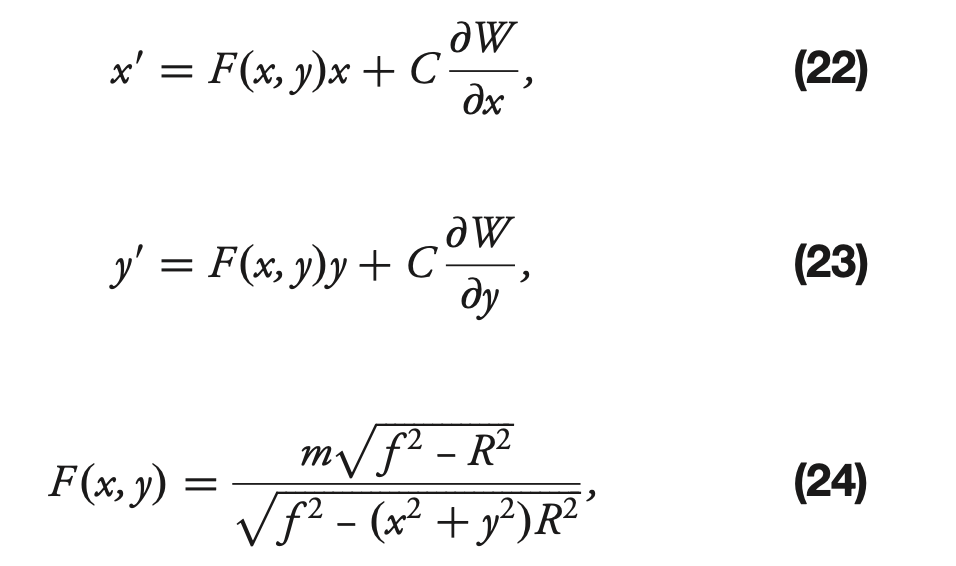

(and for off-axis, the situation is more complex, hence was not described in the paper, but covers hundreds of lines of code).

In the end we have `lutxp`, `lutyp` set of pupil coordinates. 


The intensity is transformed using the Jacobian . The Eq.13 below is from Roddier+1993:

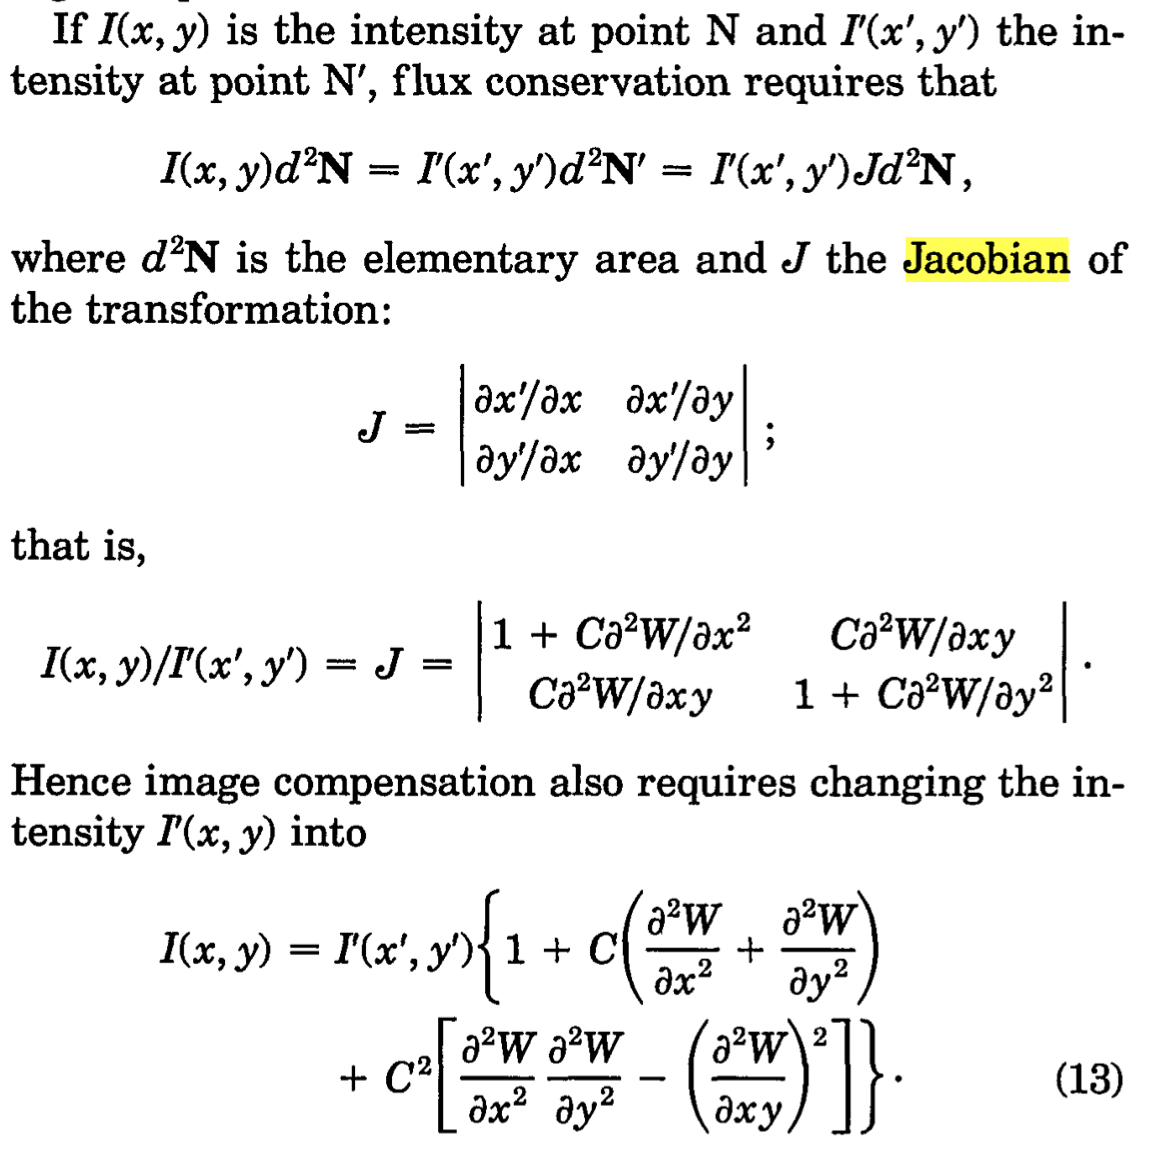



We can inspect the projection to see that for off-axis case it is far from trivial:
    
    

Text(0.5, 1.0, 'Jacobian for \noffAxis model')

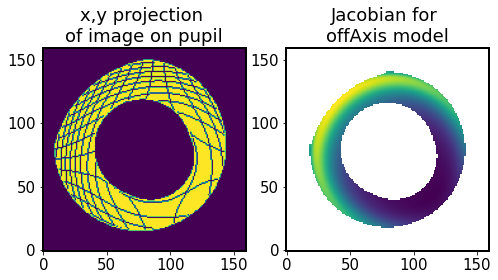

In [55]:
show_lutxyp = I1._showProjection(
            lutxp, lutyp, sensorFactor, projSamples, raytrace=False
        )

fig,ax= plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(show_lutxyp, origin='lower')
ax[0].set_title('x,y projection \nof image on pupil')

ax[1].imshow(J, origin='lower')
ax[1].set_title(f'Jacobian for \n{model} model')

In [59]:

from scipy.ndimage import generate_binary_structure, iterate_structure
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.interpolate import RectBivariateSpline
from scipy.signal import correlate

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularGrad,
    ZernikeAnnularJacobian,
)


# Extend the dimension of image by 20 pixel in x and y direction
show_lutxyp = padArray(show_lutxyp, projSamples + 20)

# Get the binary matrix of image on pupil plane if raytrace=False
struct0 = generate_binary_structure(2, 1)
struct = iterate_structure(struct0, 4)
struct = binary_dilation(struct, structure=struct0, iterations=2).astype(int)
show_lutxyp = binary_dilation(show_lutxyp, structure=struct)
show_lutxyp = binary_erosion(show_lutxyp, structure=struct)

# Extract the region from the center of image and get the original one
show_lutxyp = extractArray(show_lutxyp, projSamples)

# Recenter the image
imgRecenter = I1.centerOnProjection(
    I1.getImg(), show_lutxyp.astype(float), window=20
)


Show the small effect of recentering to the template's center via cross-correlation:

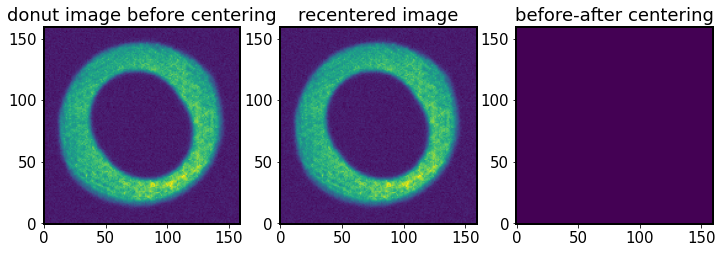

In [68]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].set_title('donut image before centering')
ax[0].imshow(I1.getImg(), origin='lower')

ax[1].set_title('recentered image')
ax[1].imshow(imgRecenter,origin='lower')

ax[2].set_title('before-after centering')
ax[2].imshow(I1.getImg()-imgRecenter, origin='lower')


In [65]:
# update the image 
I1.updateImage(imgRecenter)

# Construct the interpolant to get the intensity on (x', p') plane
# that corresponds to the grid points on (x,y)
yp, xp = np.mgrid[
    -(sm / 2 - 0.5) : (sm / 2 + 0.5), -(sm / 2 - 0.5) : (sm / 2 + 0.5)
]

xp = xp / (sm / 2 / sensorFactor)
yp = yp / (sm / 2 / sensorFactor)

# Put the NaN to be 0 for the interpolate to use
lutxp[np.isnan(lutxp)] = 0
lutyp[np.isnan(lutyp)] = 0

# Construct the function for interpolation
ip = RectBivariateSpline(yp[:, 0], xp[0, :], I1.getImg(), kx=1, ky=1)

# Construct the projected image by the interpolation
lutIp = ip(lutyp, lutxp, grid=False)


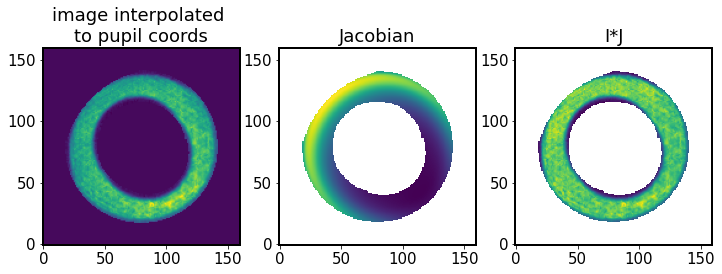

In [70]:
# image interpolated to pupil plane 
fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].set_title('image interpolated \nto pupil coords')
ax[0].imshow(lutIp, origin='lower')


ax[1].set_title('Jacobian')
ax[1].imshow(J, origin='lower')

ax[2].set_title('I*J')
ax[2].imshow(lutIp * J, origin='lower')

In [71]:
I1.updateImage(lutIp * J)

if I1.defocalType == DefocalType.Extra:
    I1.updateImage(np.rot90(I1.getImg(), k=2))

# Put NaN to be 0
imgCompensate = I1.getImg()
imgCompensate[np.isnan(imgCompensate)] = 0

# Check the compensated image has the problem or not.
# The negative value means the over-compensation from wavefront error
if np.any(imgCompensate < 0) and np.all(I1.image0 >= 0):
    print(
        "WARNING: negative scale parameter, image is within caustic, zcCol (in um)=\n"
    )
    #self.caustic = True

# Put the overcompensated part to be 0
imgCompensate[imgCompensate < 0] = 0
I1.updateImage(imgCompensate)

## END  compensate ... 



At this point, we're back in `Algorithm`,  single iteration. Now call all the above steps as a single command:

In [83]:
I1.updateImage(intraBeforeCompensate)
if not algo.caustic:
    if compMode == "zer":
        # Remove the image distortion by forwarding the image to pupil
        I1.compensate(algo._inst, algo, algo.zcomp, model)
        I2.compensate(algo._inst, algo, algo.zcomp, model)

In [ ]:
# Check the image condition. If there is the problem, done with
# this _singleItr().
if (I1.isCaustic() is True) or (I2.isCaustic() is True):
    algo.converge[:, jj] = algo.converge[:, jj - 1]
    algo.caustic = True
    #return

Now we apply the common pupil mask. This is as in Xin2015, Sec 3D: 
    
"To avoid anomalous signal due to the difference in vignetting from entering the wavefront estimation results, we mask off the intrafocal and extrafocal images using a common pupil mask, which is the logical AND of the pupil masks at the intrafocal and extrafocal field positions."

Inside `_applyI1I2mask_pupil` : 

 

In [79]:
# Get the overlap region of images and do the normalization.
if I1.getFieldXY() != I2.getFieldXY():

    # Get the overlap region of image
    I1_overlap = I1.getImg() * algo.mask_pupil

    # Rotate mask_pupil by 180 degree through rotating two times of 90
    # degree because I2 has been rotated by 180 degree already.
    I2_rotated = I2.getImg() * np.rot90(algo.mask_pupil, 2)
    
    # Do the normalization of image.
    I1_norm = I1_overlap / np.sum(I1_overlap)
    I2_norm = I2_rotated / np.sum(I2_rotated)

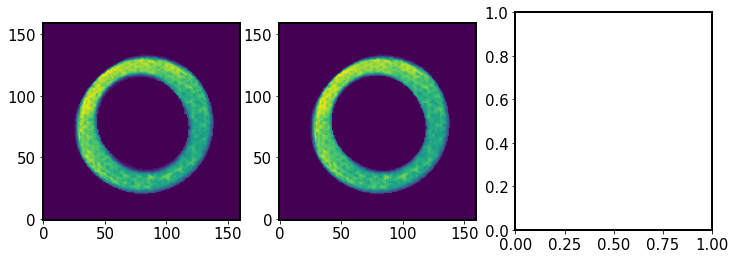

In [84]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(I1.getImg(), origin='lower')
ax[1].imshow(I1_overlap, origin='lower')
ax[1].imshow(I1_norm, origin='lower')

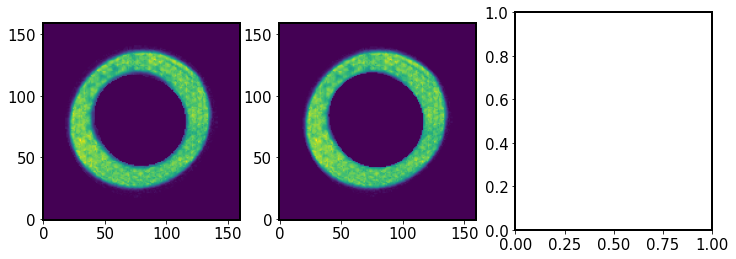

In [82]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(I2.getImg(), origin='lower')
ax[1].imshow(I2_rotated, origin='lower')
ax[1].imshow(I2_norm, origin='lower')

In [85]:
# Correct the defocal images if I1 and I2 are belong to different
# sources, which is determined by the (fieldX, field Y)
I1, I2 = algo._applyI1I2mask_pupil(I1, I2)

## Solve Poisson's equation (inner loop) 
    

It is called via 
    
    # Solve the Poisson's equation
    self.zc, self.West = self._solvePoissonEq(I1, I2, jj)

**xxx**

Next: 

   * illustrate parts of Poisson equation solving 
   * (somehow) if possible - show how the above diagnostics change from iteration to iteration 

In [41]:
algo.caustic

False

In [ ]:
# this is continued under the assumption that 
# caustic has not yet been reached 

# if not algo.caustic:
#     # Solve the Poisson's equation
#     algo.zc, algo.West = algo._solvePoissonEq(I1, I2, jj)

Inside `def _solvePoissonEq(self, I1, I2, iOutItr=0): : `

In [43]:
# Calculate the aperture pixel size
apertureDiameter = algo._inst.getApertureDiameter()
sensorFactor = algo._inst.getSensorFactor()
dimOfDonut = algo._inst.getDimOfDonutOnSensor()
aperturePixelSize = apertureDiameter * sensorFactor / dimOfDonut

# Calculate the differential Omega
dOmega = aperturePixelSize**2

# Solve the Poisson's equation based on the type of algorithm
numTerms = algo.getNumOfZernikes()
zobsR = algo.getObsOfZernikes()
PoissonSolver = algo.getPoissonSolverName()
print(PoissonSolver)

exp


In [44]:
# elif PoissonSolver == "exp":

# Use the integration method by serial expansion to solve the
# Poisson's equation

# Calculate I0 and dI
I0, dI = algo._getdIandI(I1, I2)

# Get the x, y coordinate in mask. The element outside mask is 0.
xSensor, ySensor = algo._inst.getSensorCoor()
xSensor = xSensor * algo.mask_comp
ySensor = ySensor * algo.mask_comp

# Create the F matrix and Zernike-related matrixes

# Get Zernike and gradient bases from cache.  These are each
# (nzk, npix, npix) arrays, with the first dimension indicating
# the Noll index.
zk, dzkdx, dzkdy = algo._zernikeBasisCache()

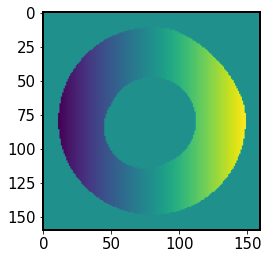

In [48]:
plt.imshow(xSensor)

In [49]:
# Eqn. (19) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
# F_j = \int (d_z I) Z_j d_Omega
F = np.tensordot(dI, zk, axes=((0, 1), (1, 2))) * dOmega
# Eqn. (20) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
# M_ij = \int I (grad Z_j) . (grad Z_i) d_Omega
#      =   \int I (dZ_i/dx) (dZ_j/dx) d_Omega
#        + \int I (dZ_i/dy) (dZ_j/dy) d_Omega
Mij = np.einsum("ab,iab,jab->ij", I0, dzkdx, dzkdx)
Mij += np.einsum("ab,iab,jab->ij", I0, dzkdy, dzkdy)
Mij *= dOmega / (apertureDiameter / 2.0) ** 2

# Calculate dz
focalLength = algo._inst.getFocalLength()
offset = algo._inst.getDefocalDisOffset()
dz = 2 * focalLength * (focalLength - offset) / offset

# Define zc
zc = np.zeros(numTerms)

# Consider specific Zk terms only
idx = algo.getZernikeTerms()

In [50]:
Mij

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  7.88542225e-04,  0.00000000e+00,
         4.91977091e-05,  4.02597038e-06,  1.77726261e-05,
         3.09967619e-04,  2.76494362e-03,  2.15467014e-04,
         4.11091012e-05, -8.92718953e-04, -2.19718404e-04,
         2.83716389e-04, -5.53507325e-06,  2.67099693e-05,
        -3.59526828e-04,  1.96987423e-04,  8.39585441e-06,
         3.22614938e-04, -3.20964610e-05,  2.76141752e-05,
        -6.73067634e-04],
       [ 0.00000000e+00,  0.00000000e+00,  7.88542225e-04,
         1.11445838e-05,  1.77726261e-05, -4.02597038e-06,
    

In [52]:
from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularEval,
    ZernikeMaskedFit,
)
# Solve the equation: M*W = F => W = M^(-1)*F
zc_tmp = np.linalg.lstsq(Mij[:, idx][idx], F[idx], rcond=None)[0] / dz
zc[idx] = zc_tmp

# Estimate the wavefront surface based on z4 - z22
# z0 - z3 are set to be 0 instead
West = ZernikeAnnularEval(
    np.concatenate(([0, 0, 0], zc[3:])), xSensor, ySensor, zobsR
)

In [54]:
zc

array([ 0.00000000e+00, -7.89738924e-07,  3.16099878e-06, -4.21900273e-07,
        6.38963879e-07,  5.92138899e-07, -1.00960004e-07, -9.06251879e-08,
       -2.76126339e-09,  4.93546657e-09,  7.63387345e-09, -4.22784396e-08,
       -5.90015864e-08, -2.83604261e-08,  3.83649584e-08,  3.17085265e-08,
       -1.32086350e-08, -2.67198724e-08, -1.20163994e-09, -6.85416690e-09,
        7.89020215e-10,  1.92269035e-08])

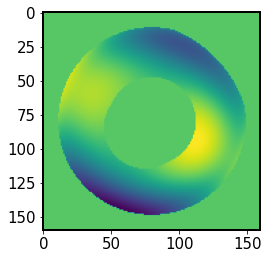

In [53]:
plt.imshow(West)

In [ ]:
 # Record/ calculate the Zk coefficient and wavefront
    if compMode == "zer":
        algo.converge[:, jj] = algo.zcomp +algo.zc

        xoSensor, yoSensor = algo._inst.getSensorCoorAnnular()
        algo.wcomp = algo.West + ZernikeAnnularEval(
            np.concatenate(([0, 0, 0], algo.zcomp[3:])),
            xoSensor,
            yoSensor,
            algo.getObsOfZernikes(),
        )

else:
    # Once we run into caustic, stop here, results may be close to real
    # aberration.
    # Continuation may lead to disastrous results.
    algo.converge[:, jj] = algo.converge[:, jj - 1]

# Record the coefficients of normal/ annular Zernike polynomials after
# z4 in unit of nm
algo.zer4UpNm = algo.converge[3:, jj] * 1e9

# Status of iteration
stopItr = False

# Calculate the difference
if jj > 0:
    diffZk = (
        np.sum(np.abs(algo.converge[:, jj] - algo.converge[:, jj - 1])) * 1e9
    )

    # Check the Status of iteration
    if diffZk < tol:
        stopItr = True

# Update the current iteration time
algo.currentItr += 1

# Show the Zk coefficients in interger in each iteration
if algo.debugLevel >= 2:
    print("itr = %d, z4-z%d" % (jj, algo.getNumOfZernikes()))
    print(np.rint(algo.zer4UpNm))
